In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
l1 = []
l2 = []

l1 = pd.read_csv("../data/counters.offline.csv")["run"]
l2 = [int(e) for e in os.popen("ls /pbs/throng/training/nantes-m2-rps-exp/data/ | grep 'mc' | cut -c 4-9").read().split("\n")[0:-2]]
#list(set(l1) & set(l2))

BASEDIR = "/pbs/throng/training/nantes-m2-rps-exp/data"
DATATYPE = ["mc", "mc", "data"]
TREE = ["gen", "events", "events"]

l3 = []
for l in l2:
    for batch in uproot.iterate(f"/pbs/throng/training/nantes-m2-rps-exp/data/run{l}.mc.root:genTree",                                
                                report = True):

        events = batch[0]
        if len(events) < 1000:
            #print("something is wrong", batch[1])
            break
            
        l3 = np.append(l3, l)
        
_ = list(set(l1) & set(l2) & set(l3))

SAMPLE_RUNS = [int(run) for run in _]

SAMPLE_RUNS = sorted(SAMPLE_RUNS)

In [3]:
on =  pd.read_csv('../data/counters.online.csv')
off = pd.read_csv('../data/counters.offline.csv')

In [4]:
#####################################################
###### EXTRACTION DES DONNEES DES FICHIER .CSV ######
#####################################################

cint7l0b = np.array([], dtype=float)
cmul7l0b = np.array([], dtype=float)
duration = np.array([], dtype=float) 
int_bunches = np.array([], dtype=float)

cint7all = np.array([], dtype=float)
cmul7all = np.array([], dtype=float)
cmsl7all = np.array([], dtype=float)

cint7ps = np.array([], dtype=float)
cmul7ps = np.array([], dtype=float)
cmsl7ps = np.array([], dtype=float)

cmsl7all0mul = np.array([], dtype=float)
cint7all0msl = np.array([], dtype=float)


for i in SAMPLE_RUNS: 
    num_run_on = on.loc[on["run"] == i]
    num_run_off = off.loc[off["run"] == i]
    
    cint7l0b = np.append(cint7l0b, num_run_on["cint7l0b"].values[0])
    cmul7l0b = np.append(cmul7l0b, num_run_on["cmul7l0b"].values[0])
    duration = np.append(duration, num_run_on["duration(s)"].values[0])
    int_bunches = np.append(int_bunches, num_run_on["interacting_bunches"].values[0])
    
    cint7all = np.append(cint7all, num_run_off["cint7all"].values[0])
    cmul7all = np.append(cmul7all, num_run_off["cmul7all"].values[0])
    cmsl7all = np.append(cmsl7all, num_run_off["cmsl7all"].values[0])
    
    cint7ps = np.append(cint7ps, num_run_off["cint7ps"].values[0])
    cmul7ps = np.append(cmul7ps, num_run_off["cmul7ps"].values[0])
    cmsl7ps = np.append(cmsl7ps, num_run_off["cmsl7ps"].values[0])
    
    cmsl7all0mul = np.append(cmsl7all0mul, num_run_off["cmsl7all&0mul"].values[0])
    cint7all0msl = np.append(cint7all0msl, num_run_off["cint7all&0msl"].values[0])    

In [5]:
#####################################################
################### CALCUL F_NORM ###################
#####################################################

F_NORM_online = np.array([], dtype=float)
F_NORM_offline_ps = np.array([], dtype=float)
F_NORM_offline_all = np.array([], dtype=float)

for i in range(len(SAMPLE_RUNS)): 
    F_NORM_online = np.append(F_NORM_online, cint7l0b[i]/cmul7l0b[i])
    F_NORM_offline_all = np.append(F_NORM_offline_all, (cmsl7all[i]*cint7all[i])/(cmsl7all0mul[i]*cint7all0msl[i]))
    F_NORM_offline_ps = np.append(F_NORM_offline_ps, (cmsl7ps[i]*cint7ps[i])/(cmsl7all0mul[i]*cint7all0msl[i]))

In [6]:
#####################################################
################ CALCUL ERROR F_NORM ################
#####################################################

err_F_NORM_online = np.array([], dtype=float)
err_F_NORM_offline_all = np.array([], dtype=float)
err_F_NORM_offline_ps = np.array([], dtype=float)
for i in range(len(SAMPLE_RUNS)):
    err_F_NORM_online = np.append(err_F_NORM_online, (cmul7l0b[i]*np.sqrt(cint7l0b[i])+cint7l0b[i]*np.sqrt(cmul7l0b[i]))/cmul7l0b[i]**2)
    
    err_F_NORM_offline_all = np.append(err_F_NORM_offline_all, F_NORM_offline_all[i] * np.sqrt( (np.sqrt(cmsl7all0mul[i])/cmsl7all0mul[i])**2 + (np.sqrt(cmsl7all[i])/cmsl7all[i])**2 
                                                                                              + (np.sqrt(cint7all[i])/cint7all[i])**2 + (np.sqrt(cint7all0msl[i])/cint7all0msl[i])**2 ) )
    
    err_F_NORM_offline_ps = np.append(err_F_NORM_offline_ps, F_NORM_offline_ps[i] * np.sqrt( (np.sqrt(cmsl7all0mul[i])/cmsl7all0mul[i])**2 + (np.sqrt(cmsl7ps[i])/cmsl7ps[i])**2 
                                                                                              + (np.sqrt(cint7ps[i])/cint7ps[i])**2 + (np.sqrt(cint7all0msl[i])/cint7all0msl[i])**2 ) )


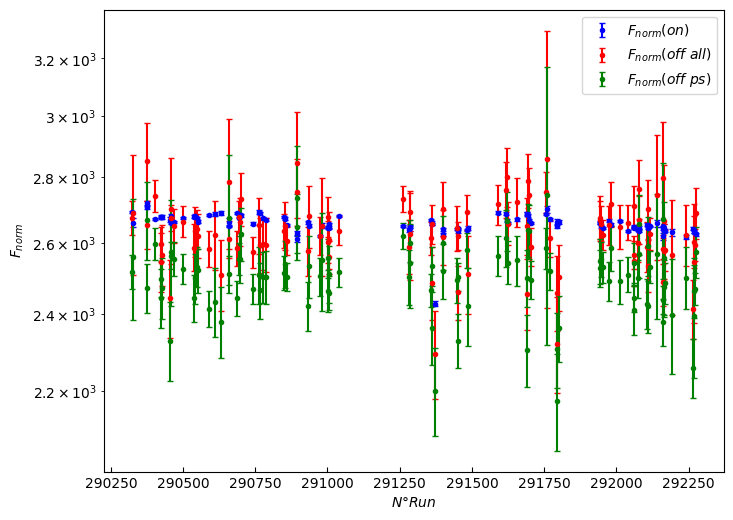

In [7]:
#####################################################
################# GRAPHIQUE F_NORM ##################
#####################################################

plt.figure(figsize=(8,6))

plt.errorbar(SAMPLE_RUNS, F_NORM_online, yerr = err_F_NORM_online, marker = '.', label=r'$F_{norm} (on)$', color='blue', linestyle = 'none', capsize = 2)
plt.errorbar(SAMPLE_RUNS, F_NORM_offline_all, yerr = err_F_NORM_offline_all, marker = '.', label=r'$F_{norm} (off~all)$', color='red', linestyle = 'none', capsize = 2)
plt.errorbar(SAMPLE_RUNS, F_NORM_offline_ps, yerr = err_F_NORM_offline_ps , marker = '.', label=r'$F_{norm} (off~ps)$', color='green', linestyle = 'none', capsize = 2 )
plt.tick_params(axis='both', direction='in')
plt.yscale("log")
plt.ylabel(r"$F_{norm}$")
plt.xlabel(r"$N° Run$")
plt.legend()

In [8]:
#####################################################
############### CALCUL F_NORM X F_PU ################
#####################################################

f_LHC = 11245

L0b = np.array([], dtype=float)
mu = np.array([], dtype=float)
F_PU = np.array([], dtype=float)

F_NORM_offline_ps_PU = np.array([], dtype=float)
F_NORM_offline_all_PU = np.array([], dtype=float)

for i in range(len(SAMPLE_RUNS)):
    L0b = np.append(L0b, cint7l0b[i]/duration[i])
    mu = np.append(mu, -np.log(1-((cint7ps[i]/cint7all[i])*L0b[i]/(int_bunches[i]*f_LHC))))
    F_PU = np.append(F_PU, mu[i]/(1-np.exp(-mu[i])))
    F_NORM_offline_ps_PU = np.append(F_NORM_offline_ps_PU, F_NORM_offline_ps[i]*F_PU[i])
    F_NORM_offline_all_PU = np.append(F_NORM_offline_all_PU, F_NORM_offline_all[i]*F_PU[i])

In [9]:
#####################################################
################## MOYENNE PONDERE ##################
#####################################################

F_NORM_pond = []
w_0 = [1]*108 

################## MOYENNE ONLINE ###################

def Online_Pond(w):
    F_NORM_onxw = np.array([], dtype=float)
    for i in range(len(SAMPLE_RUNS)):
        F_NORM_onxw = np.append(F_NORM_onxw, F_NORM_online[i]*w[i])
    return np.sum(F_NORM_onxw)/np.sum(w)

############## MOYENNE ONLINE ALL / PS ##############

def Offline_Pond(cut, w, pu):
    F_NORM_offxw = np.array([], dtype=float)
    if cut == "ps": 
        if pu == 1:
            for i in range(len(SAMPLE_RUNS)):
                F_NORM_offxw = np.append(F_NORM_offxw, F_NORM_offline_ps_PU[i]*w[i])
            return np.sum(F_NORM_offxw)/np.sum(w)
    
        elif pu == 0:
            for i in range(len(SAMPLE_RUNS)):
                F_NORM_offxw = np.append(F_NORM_offxw, F_NORM_offline_ps[i]*w[i])
            return np.sum(F_NORM_offxw)/np.sum(w)
            
    elif cut == "all":
        if pu == 1:
            for i in range(len(SAMPLE_RUNS)):
                F_NORM_offxw = np.append(F_NORM_offxw, F_NORM_offline_all_PU[i]*w[i])
            return np.sum(F_NORM_offxw)/np.sum(w)

        elif pu == 0:
            for i in range(len(SAMPLE_RUNS)):
                F_NORM_offxw = np.append(F_NORM_offxw, F_NORM_offline_all[i]*w[i])
            return np.sum(F_NORM_offxw)/np.sum(w)



    
for i in [w_0, cint7l0b, cmul7l0b, duration]:
    F_NORM_pond.append(Online_Pond(i))
    
for i in [w_0, cint7all, cmul7all, cmsl7all, duration]:
    F_NORM_pond.append(Offline_Pond("all", i, 0))
    F_NORM_pond.append(Offline_Pond("all", i, 1))
    
for i in [w_0, cint7ps, cmul7ps, cmsl7ps, duration]:  
    F_NORM_pond.append(Offline_Pond("ps", i, 0))
    F_NORM_pond.append(Offline_Pond("ps", i, 1))

In [10]:
#####################################################
############### MOYENNE PONDERE ERREUR ##############
#####################################################

err_F_NORM_pond = []

def ecart_type(meth, cut, pu, w):
    Num = np.array([], dtype = float)
    
    if meth == "on":
        mean = Online_Pond(w)
        for i in range(len(SAMPLE_RUNS)):
            Num = np.append(Num, w[i]*(F_NORM_online[i] - mean)**2)
        return np.sqrt(np.sum(Num)/np.sum(w))
            
    elif meth == "off":
        if cut == "all":
            if pu == 1:
                mean = Offline_Pond("all", w, 1)
                for i in range(len(SAMPLE_RUNS)):
                    Num = np.append(Num, w[i]*(F_NORM_offline_all_PU[i] - mean)**2)
                return np.sqrt(np.sum(Num)/np.sum(w))
                
            elif pu == 0:
                mean = Offline_Pond("all", w, 0)
                for i in range(len(SAMPLE_RUNS)):
                    Num = np.append(Num, w[i]*(F_NORM_offline_all[i] - mean)**2)
                return np.sqrt(np.sum(Num)/np.sum(w))
                
        elif cut == "ps":
            if pu == 1:
                mean = Offline_Pond("ps", w, 1)
                for i in range(len(SAMPLE_RUNS)):
                    Num = np.append(Num, w[i]*(F_NORM_offline_ps_PU[i] - mean)**2)
                return np.sqrt(np.sum(Num)/np.sum(w))
                
            elif pu == 0:
                mean = Offline_Pond("ps", w, 0)
                for i in range(len(SAMPLE_RUNS)):
                    Num = np.append(Num, w[i]*(F_NORM_offline_ps[i] - mean)**2)
                return np.sqrt(np.sum(Num)/np.sum(w))


for i in [w_0, cint7l0b, cmul7l0b, duration]:
    err_F_NORM_pond.append(ecart_type("on", "none", "none", i))

for i in [w_0, cint7all, cmul7all, cmsl7all, duration]:
    err_F_NORM_pond.append(ecart_type("off", "all", 0, i))
    err_F_NORM_pond.append(ecart_type("off", "all", 1, i))
    
for i in [w_0, cint7ps, cmul7ps, cmsl7ps, duration]:
    err_F_NORM_pond.append(ecart_type("off", "ps", 0, i))
    err_F_NORM_pond.append(ecart_type("off", "ps", 1, i))

In [11]:
#####################################################
############### VALEUR MOYENNE F_NORM ###############
#####################################################

#Calcul de la valeur moyenne des 24 F_NORM pondérés : 
mean_value_F_NORM = np.mean(F_NORM_pond)

#Calcul de l'erreur statistique et systématique de mean_value_F_NORM : 
#1) Stat
Num_stat = np.array([], dtype=float)
for i in range(len(err_F_NORM_pond)):
    Num_stat = np.append(Num_stat, (err_F_NORM_pond[i])**2)

err_stat = np.sqrt(np.sum(Num_stat)/24)

#2) Syst
Num_syst = np.array([], dtype=float)
for i in range(len(F_NORM_pond)):
    Num_syst = np.append(Num_syst, (F_NORM_pond[i] - mean_value_F_NORM)**2)
            
err_syst = np.sqrt(np.sum(Num_syst)/23)

print("mean F_NORM =", mean_value_F_NORM, "±", err_stat, "(stat) ±", err_syst, "(syst)")

mean F_NORM = 2590.973215409332 ± 69.96816923352542 (stat) ± 65.48776103119553 (syst)


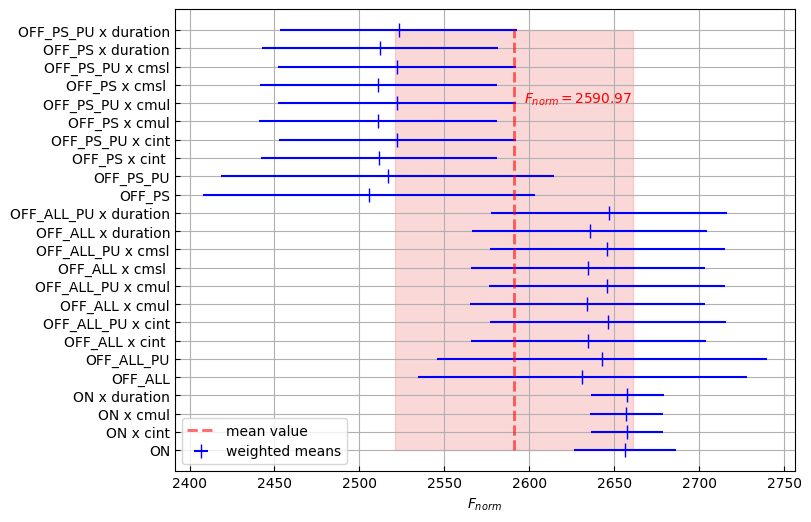

In [12]:
#####################################################
################# GRAPHIQUE F_NORMs #################
#####################################################

yticks = list(range(1, 25))

methodes = ['ON','ON x cint','ON x cmul','ON x duration',
            'OFF_ALL','OFF_ALL_PU','OFF_ALL x cint ','OFF_ALL_PU x cint',
            'OFF_ALL x cmul','OFF_ALL_PU x cmul','OFF_ALL x cmsl ','OFF_ALL_PU x cmsl',
            'OFF_ALL x duration','OFF_ALL_PU x duration',
            'OFF_PS','OFF_PS_PU','OFF_PS x cint ','OFF_PS_PU x cint',
            'OFF_PS x cmul','OFF_PS_PU x cmul','OFF_PS x cmsl ','OFF_PS_PU x cmsl',
            'OFF_PS x duration','OFF_PS_PU x duration']

F_mean = [mean_value_F_NORM]*len(yticks)
F_mean_up = [mean_value_F_NORM + err_stat]*len(yticks)
F_mean_down = [mean_value_F_NORM - err_stat]*len(yticks)

plt.figure(figsize=(8,6))
plt.yticks(yticks, methodes)
plt.errorbar(F_NORM_pond, yticks, xerr = err_F_NORM_pond , marker = '|', markersize=10, label='weighted means', color='blue', linestyle = 'none', capsize = 0 )
plt.plot(F_mean, yticks, color='red', label='mean value', alpha=0.6, linewidth=2, linestyle='--')
plt.plot(F_mean_up, yticks, alpha=0)
plt.plot(F_mean_down, yticks, alpha=0)
plt.fill_betweenx(yticks, F_mean_up, F_mean_down, color='lightcoral', alpha=0.3)
plt.text(2597, 20 ,r'$F_{norm} = 2590.97$',color ='red')

plt.grid(True)
plt.tick_params(axis='both', direction='in')
plt.xlabel(r"$F_{norm}$")
#plt.title(r"Variation of Weighted F$_{norm}$ Values")
plt.legend(loc='lower left')
plt.show()

In [13]:
MB = mean_value_F_NORM*np.sum(cmul7ps)
err_stat_MB = err_stat*np.sum(np.sum(cmul7ps)) 
err_syst_MB = err_syst*np.sum(np.sum(cmul7ps)) 

In [17]:
print("events MB =",MB,"±",err_stat_MB,"(stat)","±",err_syst_MB,"(syst)" )

events MB = 91701586949.50896 ± 2476363752.6266103 (stat) ± 2317789924.116254 (syst)
